### Tutorial of spatial imputation on slice #151673 of DLPFC using CPS

In [16]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [17]:
import scanpy as sc
import pandas as pd
import CPS

In [18]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2026'])
args.prep_scale = False
args.sigma=0.8
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/1-DLPFC/'
CPS.set_random_seed(args.seed)
args

Namespace(batch_size=256, clusters=7, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/1-DLPFC/', decoder_latent=[256, 512, 1024], distill=1.0, dropout=0.2, er_w=0.05, flow='source_to_target', freq=32, gpu=0, hvgs=3000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=6, n_spot=0, num_heads=4, prep_scale=False, radius=150, seed=2026, self_loops=True, sigma=0.8, weight_decay=0.0001)

In [19]:
section = '151673'
mask_ratio = 0.5
adata = sc.read_visium(os.path.join(args.dataset_path+section))
Ann_df = pd.read_csv(os.path.join(args.dataset_path+'1-DLPFC_annotations/', section+'_truth.txt'), 
                     sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [20]:
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs, layer='counts')
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)
sc.pp.scale(adata_hvg)

counts_layer = adata_hvg.layers['counts']
adata_hvg.obsm['hvg_features'] = adata_hvg.X
adata_hvg.obsm['hvg_counts'] = counts_layer.toarray()

In [21]:
spatial_data = CPS.SpatialGraphBuilder(args)
train_data, test_data, train_indices, _ = spatial_data.spots_perturb(adata_hvg, mask_ratio=mask_ratio)
print(train_data)

Data(x=[1820, 3000], edge_index=[2, 15318], y=[1820, 3000], pos=[1820, 2], num_nodes=1820, num_genes=3000)


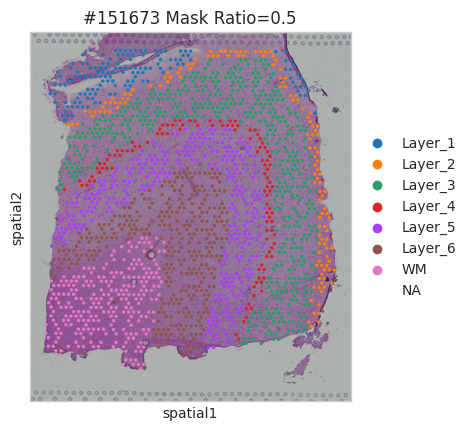

In [22]:
sc.pl.spatial(adata_hvg[train_indices], img_key="hires", 
              color=["Ground Truth"], 
              title=[f'#{section} Mask Ratio={mask_ratio}'])

In [23]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(train_data, print_every=100)

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch   0: Train[Total:2.7590, T:1.0400, S:0.9472, D:0.7718]

Epoch 100: Train[Total:1.4617, T:0.4777, S:0.4787, D:0.5054]

Epoch 200: Train[Total:1.2021, T:0.4702, S:0.4728, D:0.2590]

Epoch 300: Train[Total:1.1079, T:0.4653, S:0.4698, D:0.1728]

Epoch 400: Train[Total:1.0494, T:0.4612, S:0.4681, D:0.1201]

Epoch 500: Train[Total:1.0063, T:0.4578, S:0.4668, D:0.0817]

Epoch 600: Train[Total:0.9787, T:0.4556, S:0.4655, D:0.0576]

Epoch 700: Train[Total:0.9567, T:0.4534, S:0.4640, D:0.0392]

Epoch 800: Train[Total:0.9422, T:0.4523, S:0.4631, D:0.0268]

Epoch 900: Train[Total:0.9323, T:0.4510, S:0.4622, D:0.0190]

Epoch 999: Train[Total:0.9235, T:0.4496, S:0.4613, D:0.0126]


Compute the metrics on test dataset

In [24]:
metrics = cps_model.evaluate_spots_imputation(test_data=test_data, experiment_name='DLPFC_SI', use_log1p=True)

Performing spots imputation, number of test spots: 1819

Computing metrics on **Log1p Transformed** data...

Spatial imputation metrics [Log1p Transformed]

[global flatten metrics]
MSE:           0.060983
RMSE:          0.246948
MAE:           0.132609
R²:            0.643342
Pearson:       0.807222
Spearman:      0.498659

[sample mean metrics]
CS:               0.799853
CS nonzero:       0.895369
Pearson:          0.772314
Pearson nonzero:  0.776372
Spearman:         0.483299
Spearman nonzero: 0.639881
SAM:              36.455551°
SAM nonzero:      26.444070°
MSE:              0.060983
MSE nonzero:      0.267960
MAE:              0.132609
MAE nonzero:      0.446617

 num of sample: 1819.0
Metrics saved to: ./results/DLPFC_SI_metrics.json


### Analysis of the imputed gene expression

In [25]:
# mask_ratio=0 to get all the inference data
train_data, _, _, _ = spatial_data.spots_perturb(adata_hvg, mask_ratio=0.)
imputed_expr, z_s = cps_model.infer_postion(train_data)
imputed_expr.shape

torch.Size([3639, 3000])

In [26]:
adata_hvg.layers['imputed'] = imputed_expr.detach().cpu().numpy()
adata_hvg.obsm['z_s'] = z_s.detach().cpu().numpy()
adata_hvg

AnnData object with n_obs × n_vars = 3639 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'hvg_features', 'hvg_counts', 'z_s'
    layers: 'counts', 'imputed'

In [27]:
import numpy as np
adata_hvg.layers['log1p_raw'] = np.log1p(adata_hvg.layers['counts']) 
adata_hvg.layers['log1p_imputed'] = np.log1p(adata_hvg.layers['imputed'])

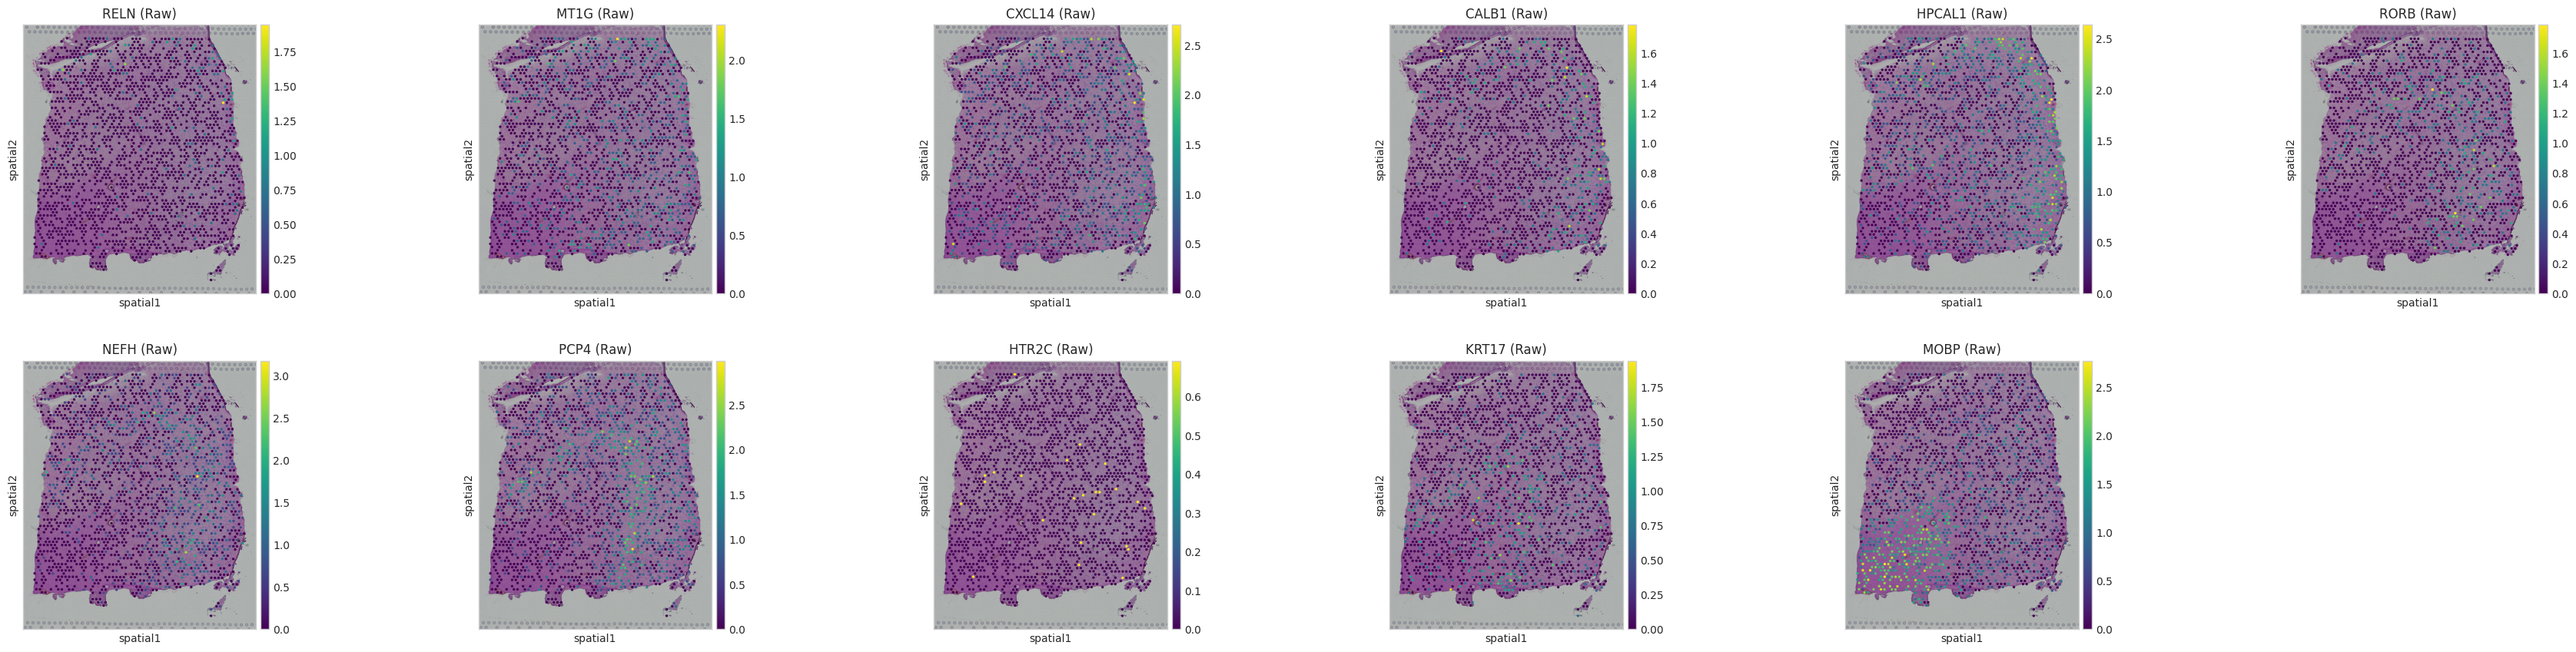

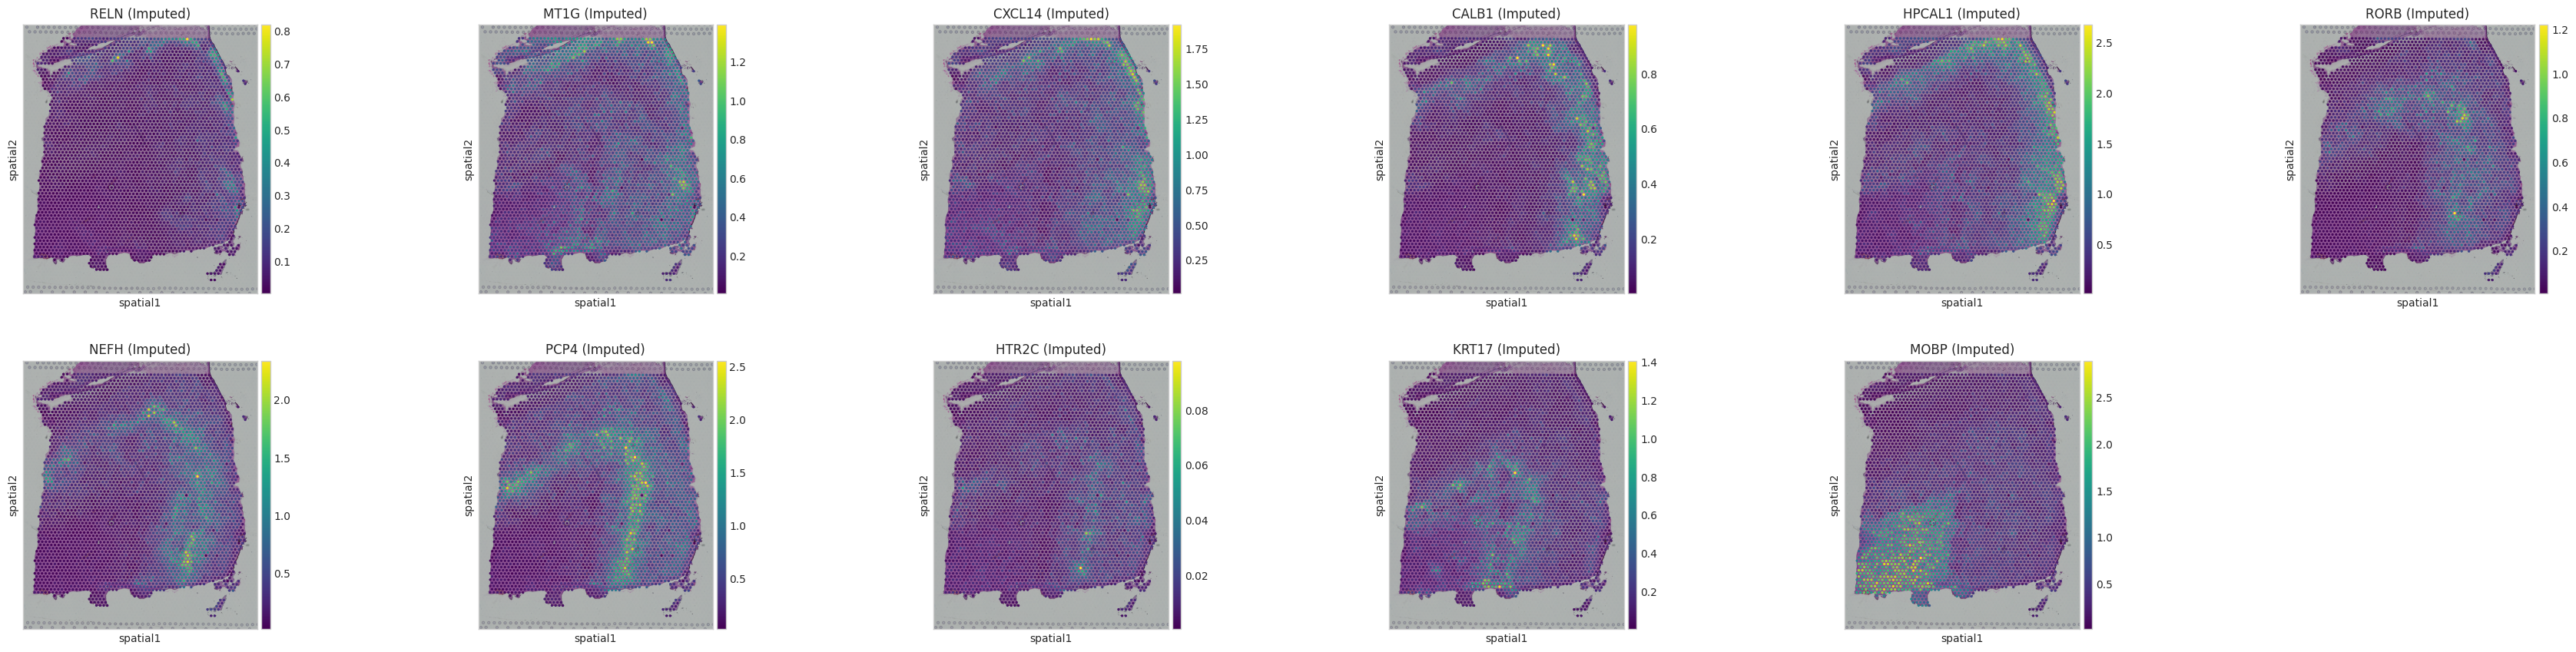

In [28]:
genes_to_plot = [
    'RELN',    # Layer 1
    'MT1G',    # Layer 1
    'CXCL14',  # Layer 2
    'CALB1',   # Layer 2
    'HPCAL1',  # Layer 2/3
    'RORB',    # Layer 4 
    'NEFH',    # Layer 4
    'PCP4',    # Layer 5 
    'HTR2C',   # Layer 5
    'KRT17',   # Layer 6
    'MOBP'     # White Matter
]

 # show input genes   
sc.pl.spatial(adata_hvg[train_indices], cmap='viridis',      
              color=genes_to_plot, layer='log1p_raw', 
              title=[f"{g} (Raw)" for g in genes_to_plot], ncols=6)
sc.pl.spatial(adata_hvg, cmap='viridis',
              color=genes_to_plot, layer='log1p_imputed',
              title=[f"{g} (Imputed)" for g in genes_to_plot], ncols=6)

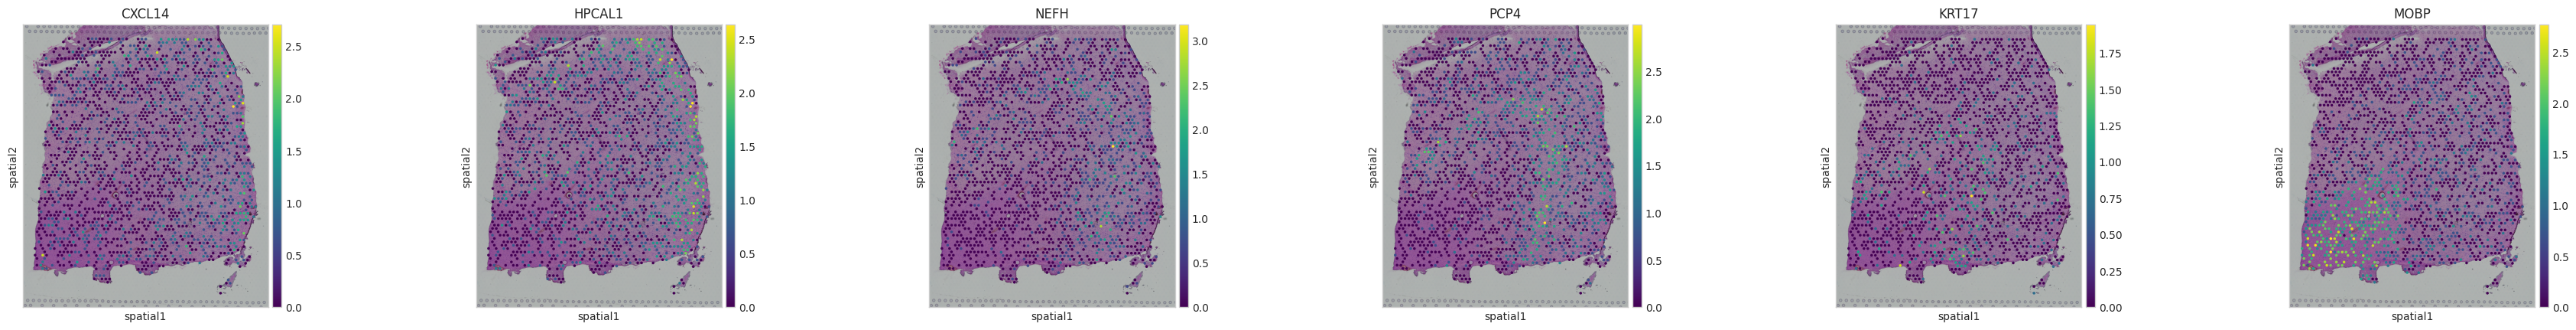

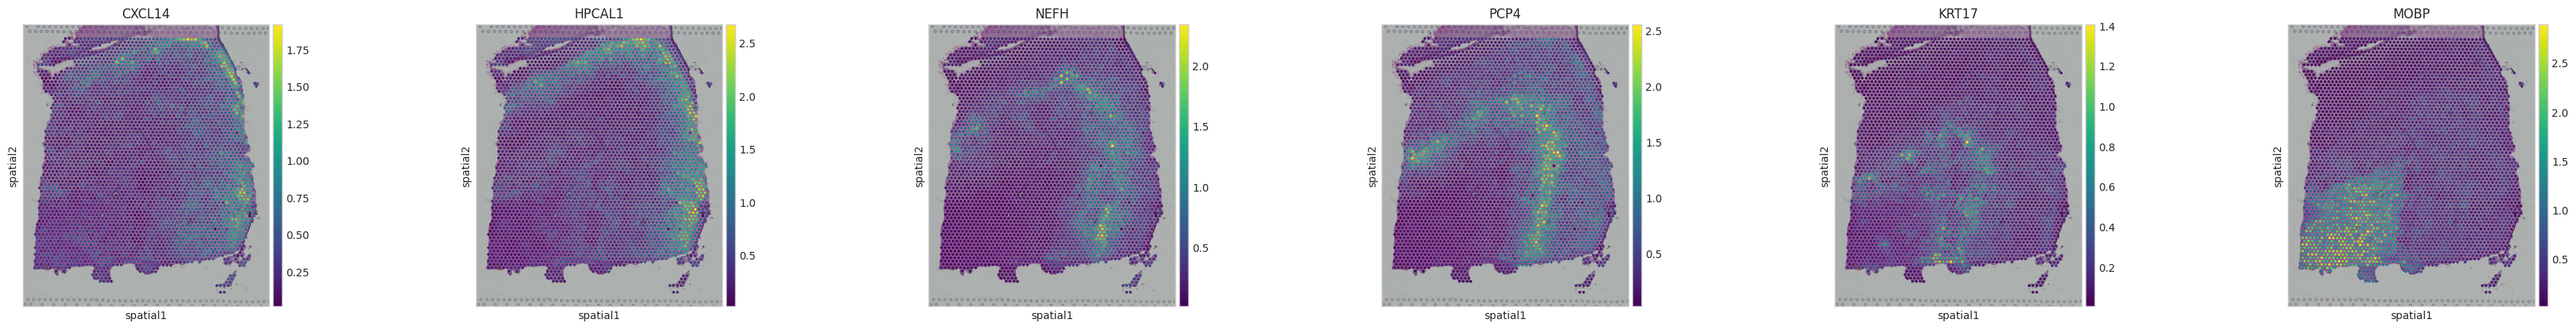

In [29]:
# used genes in CPS paper
genes_to_plot = [
    'CXCL14',  # Layer 2
    'HPCAL1',  # Layer 2/3
    'NEFH',    # Layer 4
    'PCP4',    # Layer 5 
    'KRT17',   # Layer 6
    'MOBP'     # White Matter
]
sc.pl.spatial(adata_hvg[train_indices], cmap='viridis',
              color=genes_to_plot, layer='log1p_raw',
              title=[f"{g}" for g in genes_to_plot], ncols=6)
sc.pl.spatial(adata_hvg, cmap='viridis',
              color=genes_to_plot, layer='log1p_imputed',
              title=[f"{g}" for g in genes_to_plot], ncols=6)

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

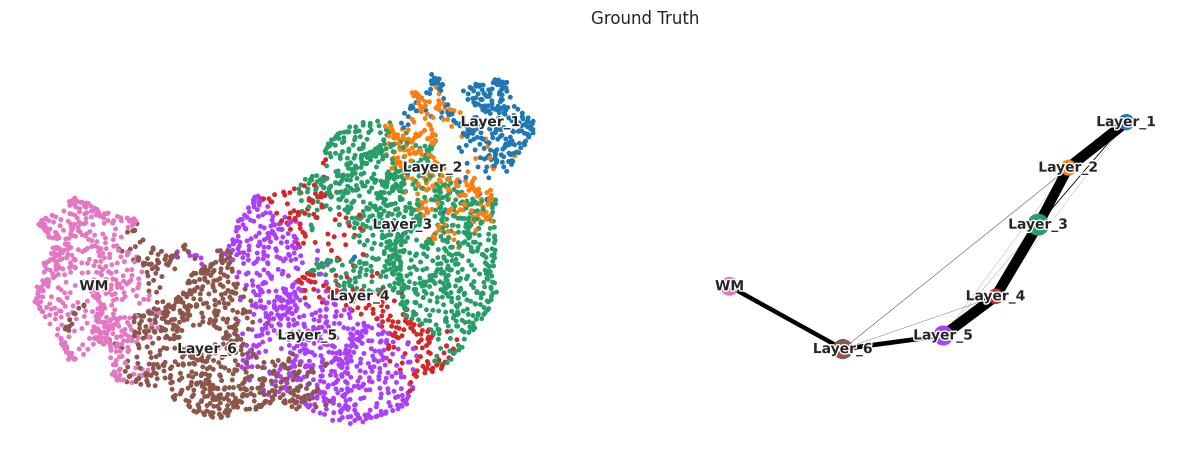

In [30]:
sc.pp.neighbors(adata_hvg, use_rep='z_s', n_neighbors=25)
sc.tl.umap(adata_hvg)
adata_hvg = adata_hvg[adata_hvg.obs['Ground Truth'].notna(),:]
sc.tl.paga(adata_hvg, groups='Ground Truth', use_rna_velocity=False)
sc.pl.paga_compare(adata_hvg, frameon=False, size=50,basis='umap', 
                   legend_fontoutline=2, show=False, title=None)